In [174]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.patches as patches

import pylab as plt
#!pip install --user gpy 
#!pip install --user plotly 

import GPy
from IPython.display import display
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#GPy.plotting.change_plotting_library('plotly')
GPy.plotting.change_plotting_library('plotly_offline')

sns.set(color_codes=True)

### Load data
Load raw data, drop some values missed in data preparation, drop unnecessary columns, show data head

In [153]:
data_raw = pd.read_csv('data/cleaned_data2.csv').drop(columns=['Unnamed: 0'])
print(len(data_raw))

# Drop some bad samples from data
data_raw = data_raw[data_raw.number_of_rooms != ' ']
data_raw = data_raw[data_raw.dist_center < 100]

# Drop na
data_raw = data_raw.dropna()
print(len(data_raw))  # a lot of na, impute values?

# Drop unnecessary columns, they are still in data_raw if needed later
data = data_raw.drop(columns=['neighborhood', 'rooms', 'energy_class'])
data.head(5)

3432
2242


,type_kt,type_rt,type_ok,elevator,price,price_per_square_meter,number_of_rooms,square_meters,year,condition,floor_num,top_floor,bottom_floor,floor_frac,lat,lng,dist_center
0,1,0,0,1,191050,10055,1,19.0,1929,2,5.0,True,False,1.000000,60.167458,24.931075,0.485608
2,1,0,0,1,167000,6680,1,25.0,1940,1,6.0,True,False,1.000000,60.188258,24.955949,2.270341
3,1,0,0,0,157000,6181,1,25.4,1951,1,1.0,False,False,0.250000,60.202747,24.905494,4.093763
5,1,0,0,1,181500,6259,1,29.0,1963,2,2.0,False,False,0.500000,60.221863,24.896194,6.249120
6,1,0,0,0,186000,6414,1,29.0,1943,2,1.0,False,False,0.333333,60.214163,24.950781,4.984236


## Data exploration
In this section we explore the data to get a better understanding of it

### Plot variables
Next, we plot some variables to get a feel for the dataset. The goal of this project is to predict price per $m^2$, so most of the plots have that variable on y axis

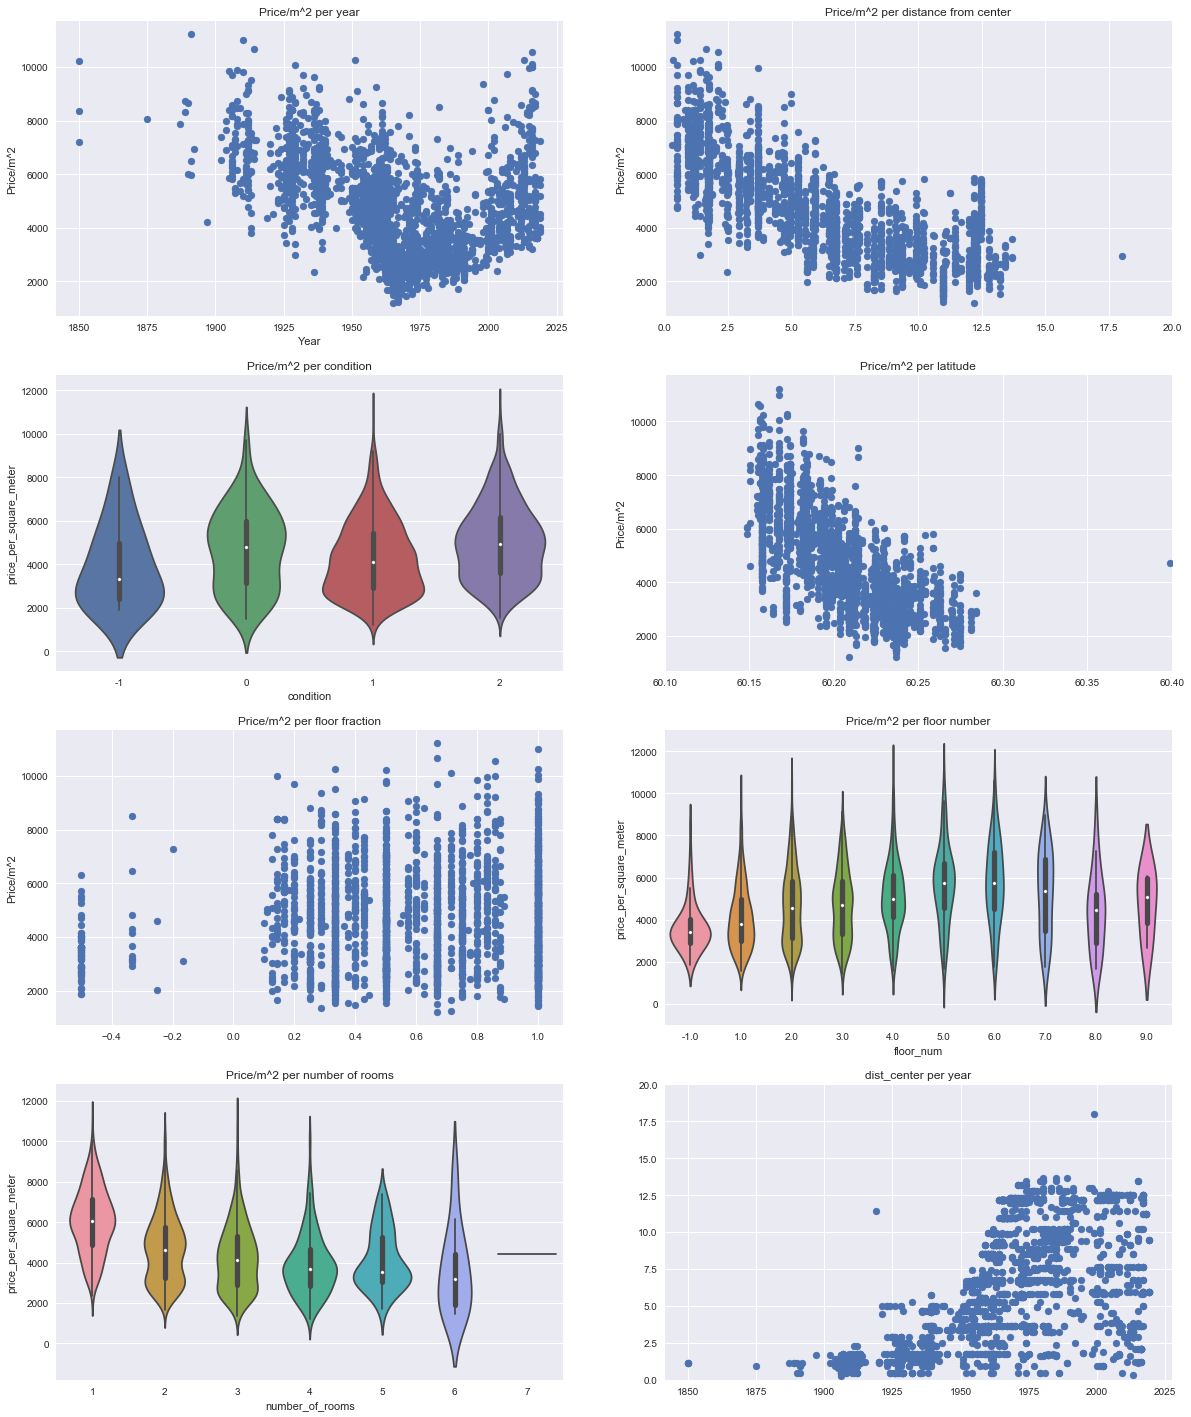

In [88]:
# Plot some shit
plt.figure(figsize=(20, 25))
plt.subplot(4,2,1)
plt.title('Price/m^2 per year')
plt.xlabel('Year')
plt.ylabel('Price/m^2')
plt.scatter(data=data, x='year', y='price_per_square_meter')

plt.subplot(4,2,2)
plt.xlim(0, 20)
plt.title('Price/m^2 per distance from center')
plt.ylabel('Price/m^2')
plt.scatter(data=data, x='dist_center', y='price_per_square_meter')

plt.subplot(4,2,3)
#plt.xlim(0, 20)
plt.title('Price/m^2 per condition')
plt.ylabel('Price/m^2')
sns.violinplot(data=data, x='condition', y='price_per_square_meter')

plt.subplot(4,2,4)
plt.xlim(60.1, 60.4)
plt.title('Price/m^2 per latitude')
plt.ylabel('Price/m^2')
plt.scatter(data=data, x='lat', y='price_per_square_meter')

plt.subplot(4,2,5)
plt.title('Price/m^2 per floor fraction')
plt.ylabel('Price/m^2')
plt.scatter(data=data, x='floor_frac', y='price_per_square_meter')

plt.subplot(4,2,6)
plt.title('Price/m^2 per floor number')
sns.violinplot(data=data, x='floor_num', y='price_per_square_meter', jitter=True)

plt.subplot(4,2,7)
plt.title('Price/m^2 per number of rooms')
sns.violinplot(data=data, x='number_of_rooms', y='price_per_square_meter', jitter=True)

plt.subplot(4,2,8)
plt.title('dist_center per year')
plt.ylim(0, 20)
plt.scatter(data=data, x='year', y='dist_center')


#plt.savefig('fig/year_price_scatter.eps', format='eps')

### Correlation plot
Correlation plot gives nice overview of the variable correlations. Interesting observations include that price per square meter and price differ on a number of variables, such as house type. Year and distance from city center also correlate.

Text(0.5,1,'Correlation plot')

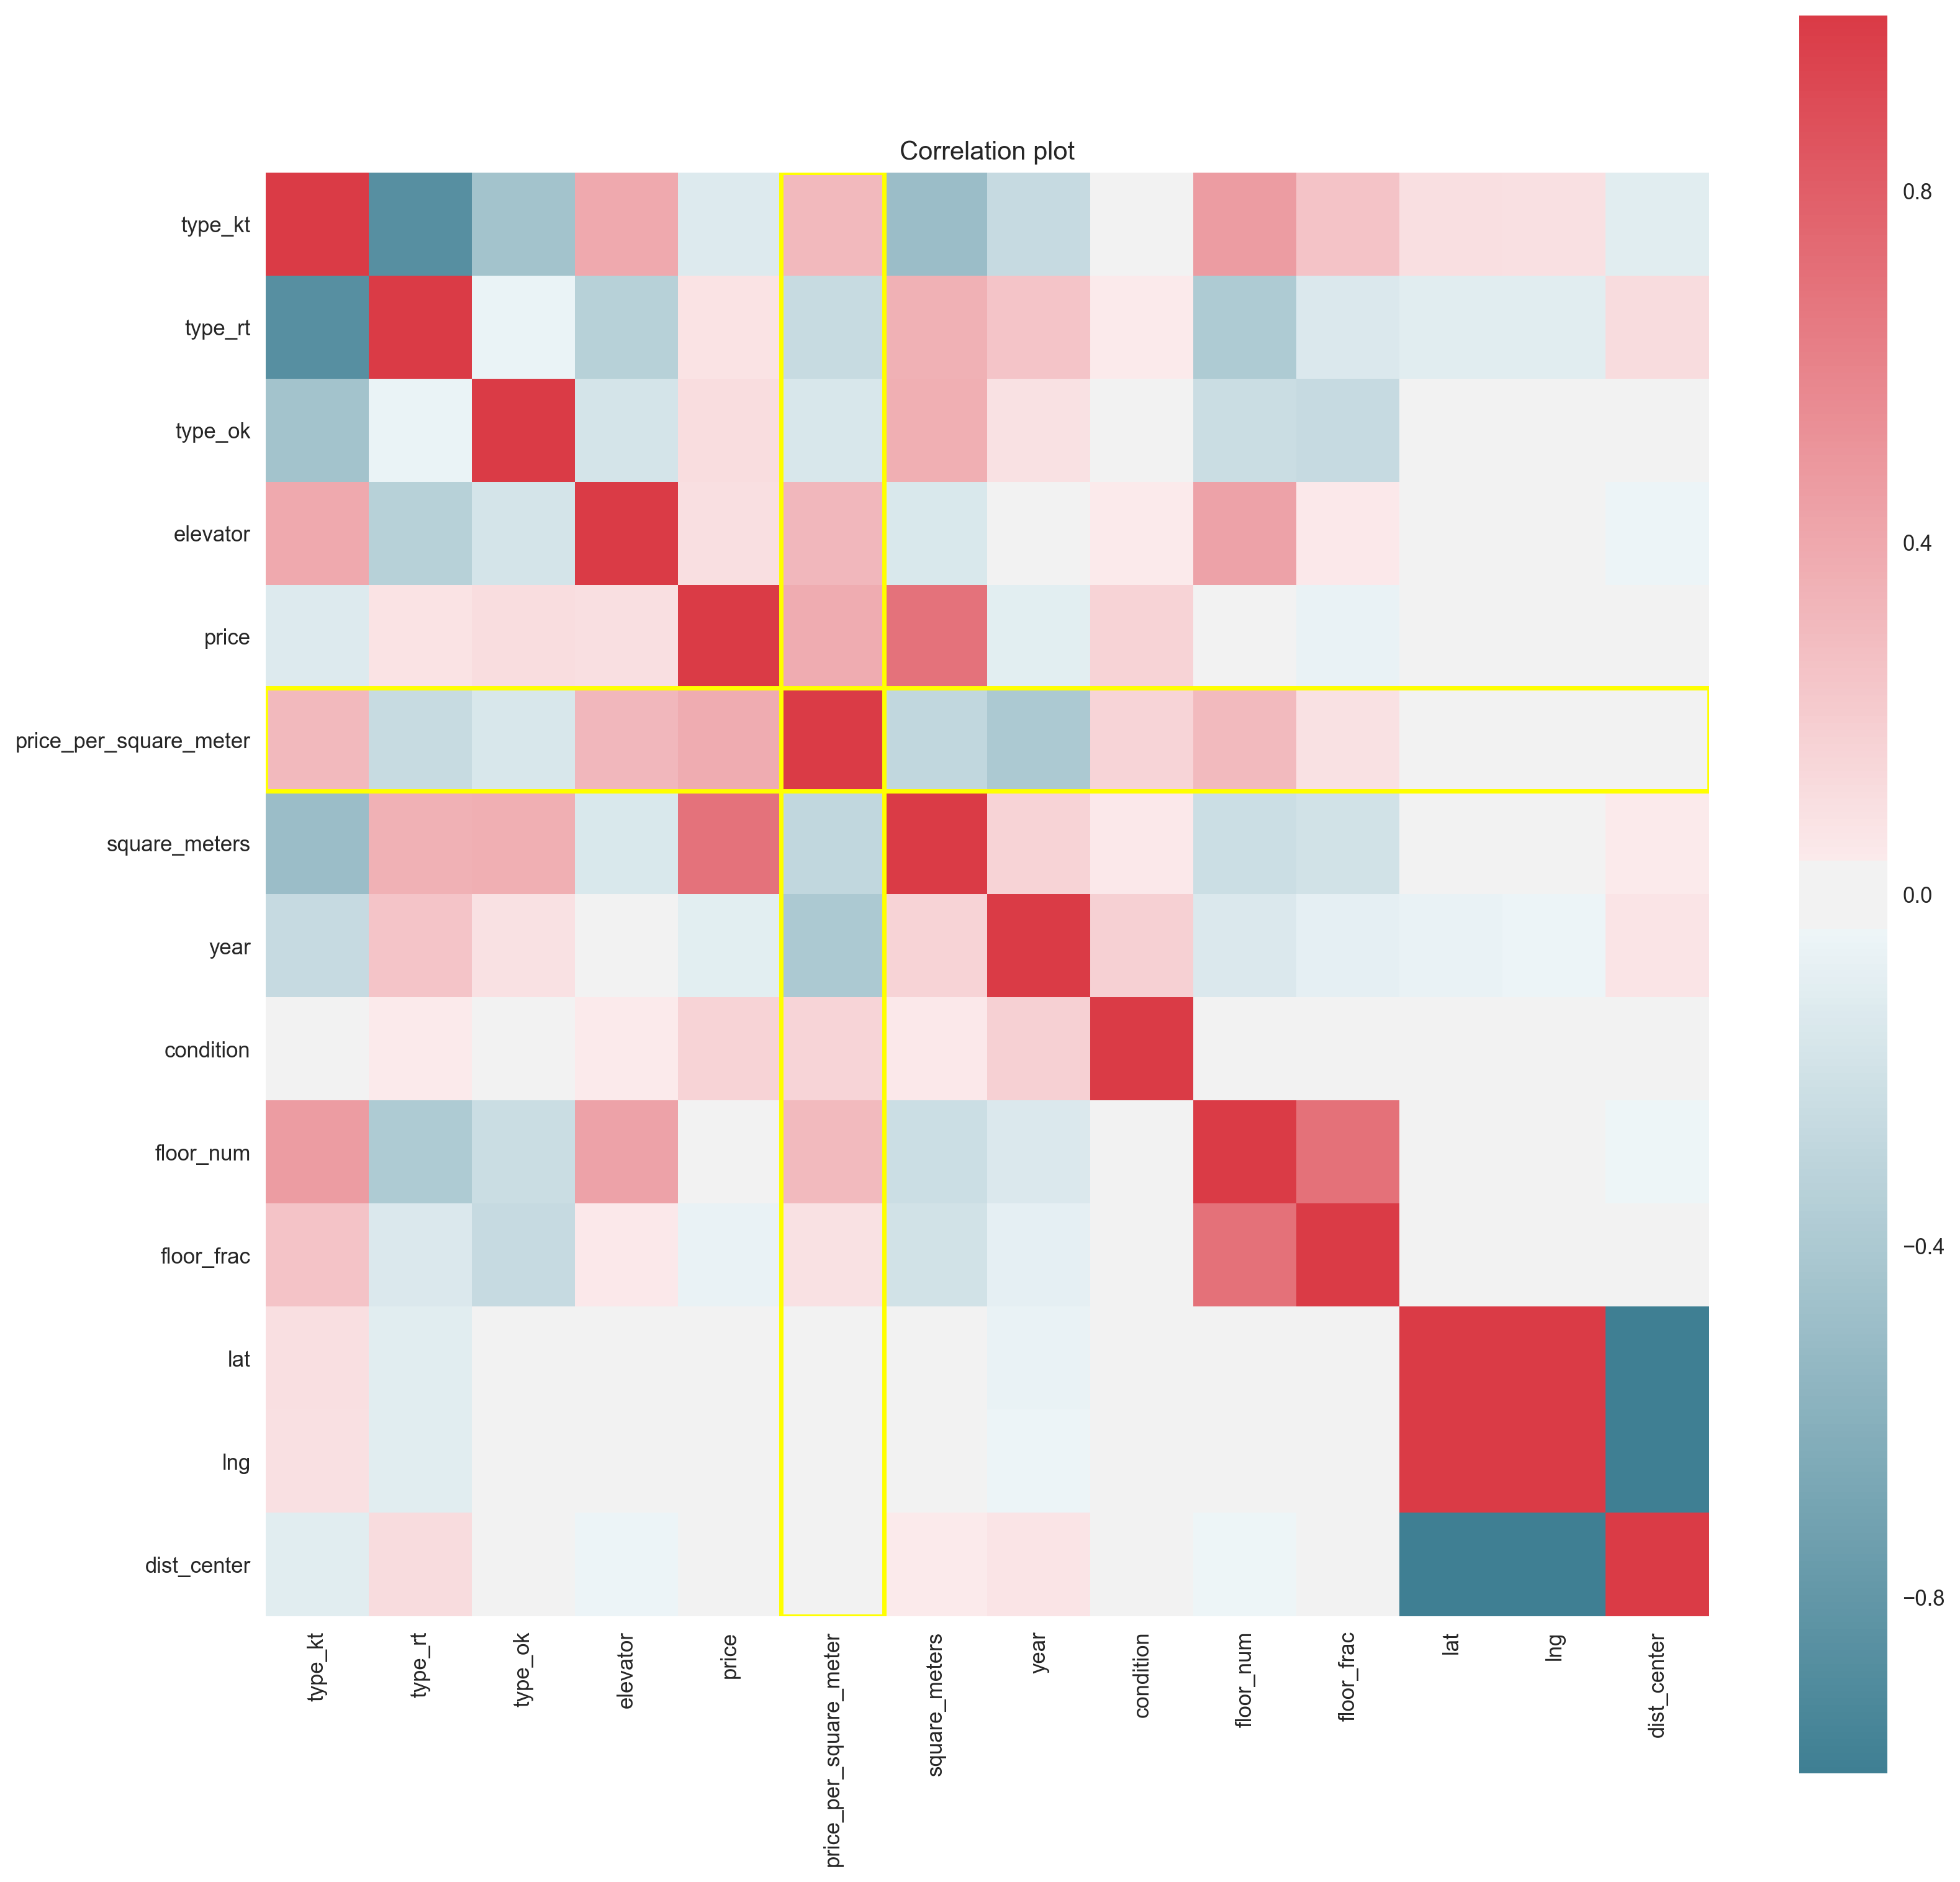

In [75]:
corr = data.corr()
f, ax = plt.subplots(figsize=(15, 15), dpi=250)
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

ax.add_patch(
    patches.Rectangle(
        (5, 0),
        1,
        14,
        fill=False,
        linewidth=2,
        color='yellow'
    )
)
ax.add_patch(
    patches.Rectangle(
            (0, 5),
            14,
            1,
            fill=False,
            linewidth=2,
            color='yellow'
    )
)

plt.title('Correlation plot')

### TSNE embedding
Next, we do tsne embedding to visualize the whole dataset in 2D. Price related variables are dropped as we wish to predict those variables and as such can use them to color the tsne plots to see if any clusters form where the price or price per square meter are different.

We plot a couple of more tsne plots where the coloring is some other interesting variable.

In [154]:
# TSNE, drop price and price per square meter as we want to predict those variables
data_tsne_embedded = TSNE(n_components=2).fit_transform(data.drop(columns=['price', 'price_per_square_meter']))

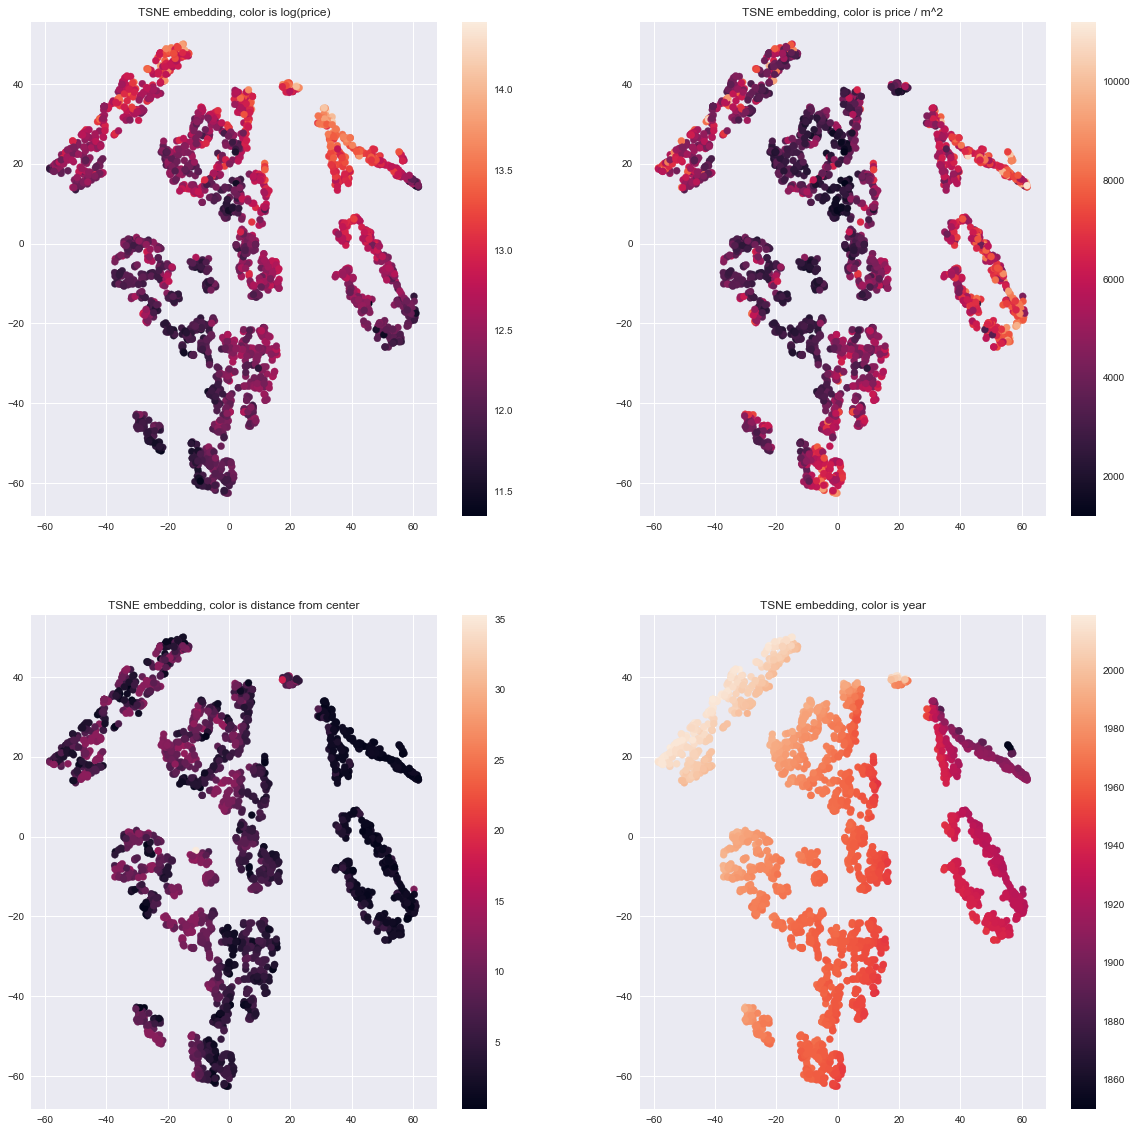

In [173]:
plt.figure(figsize=(20, 20))
plt.subplot(2,2,1)
plt.title('TSNE embedding, color is log(price)')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = np.log(data.price))
plt.colorbar()

plt.subplot(2,2,2)
plt.title('TSNE embedding, color is price / m^2')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = data.price_per_square_meter)
plt.colorbar()

plt.subplot(2,2,3)
plt.title('TSNE embedding, color is distance from center')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = data.dist_center)
plt.colorbar()

plt.subplot(2,2,4)
plt.title('TSNE embedding, color is year')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = data.year)
plt.colorbar()

### PCA analysis
We next do PCA analysis for the data, similarly to the TSNE embedding. We see that the first two components explain 99.1% of the variance, so most likely it would be beneficial to use just these to fit the GP. 

0.9911998069159123


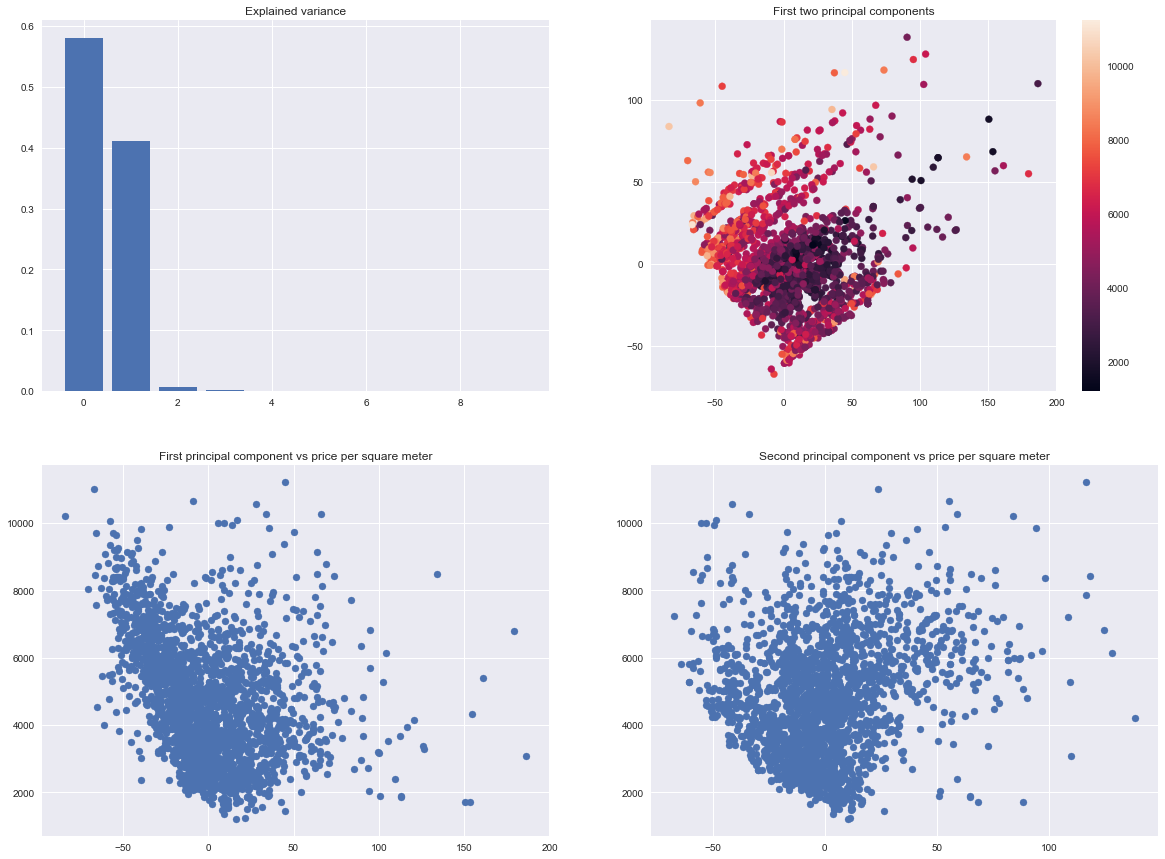

In [198]:
# TSNE, drop price and price per square meter as we want to predict those variables
pca_data = data.drop(columns=['price', 'price_per_square_meter'])

data_pca_model = PCA(n_components=10).fit(pca_data)
data_pca_embedded = PCA(n_components=10).fit_transform(pca_data)

ratios = data_pca_model.explained_variance_ratio_
print(ratios[0]+ ratios[1])

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.bar(np.arange(0,len(ratios)), ratios)
plt.title('Explained variance')

plt.subplot(2,2,2)
plt.title('First two principal components')
plt.scatter(x = data_pca_embedded[:,0], y = data_pca_embedded[:,1], c = data.price_per_square_meter)
plt.colorbar()

plt.subplot(2,2,3)
plt.title('First principal component vs price per square meter')
plt.scatter(x = data_pca_embedded[:,0], y = data.price_per_square_meter)

plt.subplot(2,2,4)
plt.title('Second principal component vs price per square meter')
plt.scatter(x = data_pca_embedded[:,1], y = data.price_per_square_meter)

## GAUSSIAN PROCESS FIT

In [143]:
def model_information(model, x_test=None, y_test=None, plot_test_data = False):
    print(model)
 
    log_marginal_likelihood = model.log_likelihood()
    print('\nLog marginal likelihood:')
    print(log_marginal_likelihood)
     
    if x_test is not None and y_test is not None:
        predictions = model.predict(x_test)[0]
        mean_test_error = np.mean((predictions - y_test)**2)
        print('\nMean squared test error:')
        print(mean_test_error)

        mlppd = np.mean(model.log_predictive_density(x_test, y_test))
        print('\nMLPPD:')
        print(mlppd)
 
    fig = model.plot()
        
    if plot_test_data:
        fig_data = fig[0]['data']
        test_info = {'type': 'scatter', 
                     'x': np.squeeze(x_test,1), 
                     'y': np.squeeze(y_test,1), 
                     'mode': 'markers', 
                     'showlegend': True, 
                     'marker': {'color': 'red', 'colorscale': None}, 
                     'name': 'Test'}
        fig_data.append(test_info)
        fig[0]['data'] = fig_data
    
    
    GPy.plotting.show(fig)


### Train-test split

In [145]:
# Split data to train and test sets
# Predict house prices after 2017
cutoff_year = 2000

train_data = data[data.year < cutoff_year]
test_data = data[data.year >= cutoff_year]

print(len(train_data), len(test_data))

1899 343


In [149]:
model_information(m, X_test, Y_test, plot_test_data = True)


Name : GP regression
Objective : 32171.09230213258
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |   33028.07951069622  |      +ve      |        
  rbf.lengthscale          |  239.78921445420565  |      +ve      |        
  Gaussian_noise.variance  |  101255.53452926608  |      +ve      |        

Log marginal likelihood:
-32171.09230213258

Mean squared test error:
11742151.163534634

MLPPD:
-64.4611300840854
This is the format of your plot grid:
[ (1,1) x1,y1 ]



In [147]:
X_train = np.array(train_data[['year']])
Y_train = np.array(train_data['price_per_square_meter'])[:, None]

X_test = np.array(test_data[['year']])
Y_test = np.array(test_data['price_per_square_meter'])[:, None]

kernel = GPy.kern.RBF(input_dim=X_train.shape[1], variance=1., lengthscale=1.) 

m = GPy.models.GPRegression(X_train, Y_train, kernel)
m.optimize(messages=True)

model_information(m, X_test, Y_test, plot_test_data = True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s78  0006   3.052138e+08   2.112624e+15 
    08s30  0018   9.363559e+06   2.343883e+09 
    15s24  0033   4.175887e+05   3.083392e+06 
    17s95  0039   6.739353e+04   1.429305e+03 
    19s33  0042   3.789652e+04   3.709895e+02 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:

invalid value encountered in multiply



    21s27  0046   3.217109e+04   2.208427e+02 
Runtime:     21s27
Optimization status: Converged


Name : GP regression
Objective : 32171.09230213258
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |   33028.07951069622  |      +ve      |        
  rbf.lengthscale          |  239.78921445420565  |      +ve      |        
  Gaussian_noise.variance  |  101255.53452926608  |      +ve      |        

Log marginal likelihood:
-32171.09230213258

Mean squared test error:
11742151.163534634

MLPPD:
-64.4611300840854
This is the format of your plot grid:
[ (1,1) x1,y1 ]



In [93]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]



IndexError: index 1 is out of bounds for axis 1 with size 1

In [94]:


slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(0,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing_vertical')



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]



TypeError: calculated free_dims [] from visible_dims None and fixed_dims [0] is neither 1D nor 2D

In [95]:
m.optimize(messages=True)
#m.optimize_restarts(num_restarts = 10)

display(m)
fig = m.plot()
GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.930911e+04   4.542646e-08 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:

overflow encountered in expm1




    02s84  0004   1.930911e+04   9.767605e-10 
Runtime:     02s84
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,21247518.197395407,+ve,
rbf.lengthscale,7.1502921456802335,+ve,
Gaussian_noise.variance,1617702.8693236513,+ve,


This is the format of your plot grid:
[ (1,1) x1,y1 ]

